In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    init_channel = 256
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/3))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 256)        1024      
_________________________________________________________________
activation (Activation)      (None, 16000, 256)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 4096000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 256)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 256)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9653 - acc: 0.4222
Epoch 00001: val_loss improved from inf to 1.54442, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_4_conv_checkpoint/001-1.5444.hdf5
36805/36805 [==============================] - 415s 11ms/sample - loss: 1.9652 - acc: 0.4222 - val_loss: 1.5444 - val_acc: 0.5167
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2705 - acc: 0.6099
Epoch 00002: val_loss improved from 1.54442 to 1.13743, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_4_conv_checkpoint/002-1.1374.hdf5
36805/36805 [==============================] - 413s 11ms/sample - loss: 1.2706 - acc: 0.6099 - val_loss: 1.1374 - val_acc: 0.6452
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0540 - acc: 0.6768
Epoch 00003: val_loss did not improve from 1.13743
36805/36805 [=====

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1386 - acc: 0.9548
Epoch 00027: val_loss did not improve from 0.91277
36805/36805 [==============================] - 415s 11ms/sample - loss: 0.1387 - acc: 0.9548 - val_loss: 1.1522 - val_acc: 0.7699
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9554
Epoch 00028: val_loss did not improve from 0.91277
36805/36805 [==============================] - 415s 11ms/sample - loss: 0.1400 - acc: 0.9554 - val_loss: 1.1829 - val_acc: 0.7678
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1210 - acc: 0.9603
Epoch 00029: val_loss did not improve from 0.91277
36805/36805 [==============================] - 415s 11ms/sample - loss: 0.1210 - acc: 0.9603 - val_loss: 1.3837 - val_acc: 0.7284
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1172 - acc: 0.9623
Epoch 00030: val_loss did not improve from 0.91277
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0672 - acc: 0.9803
Epoch 00057: val_loss did not improve from 0.91277
36805/36805 [==============================] - 416s 11ms/sample - loss: 0.0672 - acc: 0.9803 - val_loss: 1.3208 - val_acc: 0.7682
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0627 - acc: 0.9812
Epoch 00058: val_loss did not improve from 0.91277
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0629 - acc: 0.9812 - val_loss: 1.4386 - val_acc: 0.7594
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0700 - acc: 0.9793
Epoch 00059: val_loss did not improve from 0.91277
36805/36805 [==============================] - 416s 11ms/sample - loss: 0.0702 - acc: 0.9793 - val_loss: 1.2999 - val_acc: 0.7803
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0687 - acc: 0.9792
Epoch 00060: val_loss did not improve from 0.91277
36805/36805 [=====

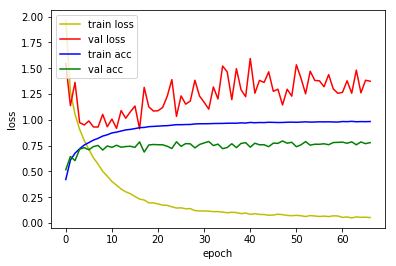

4815/4815 [==============================] - 17s 4ms/sample - loss: 1.0501 - acc: 0.7425
Loss: 1.050109894302899 Accuracy: 0.74247146

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8993 - acc: 0.4221
Epoch 00001: val_loss improved from inf to 1.38086, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_5_conv_checkpoint/001-1.3809.hdf5
36805/36805 [==============================] - 424s 12ms/sample - loss: 1.8993 - acc: 0.4221 - val_loss: 1.3809 - val_acc: 0.5602
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1975 - acc: 0.6273
Epoch 00002: val_loss improved from 1.38086 to 1.11458, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_5_conv_checkpoint/002-1.1146.hdf5
36805/36805 [==============================] - 420s 11ms/sample - loss: 1.1976 - acc: 0.6273 - val_loss: 1.1146 - val_acc: 0.6613
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2033 - acc: 0.9340
Epoch 00028: val_loss did not improve from 0.59682
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.2033 - acc: 0.9340 - val_loss: 0.5998 - val_acc: 0.8549
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1959 - acc: 0.9346
Epoch 00029: val_loss did not improve from 0.59682
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.1958 - acc: 0.9346 - val_loss: 0.6737 - val_acc: 0.8351
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1854 - acc: 0.9392
Epoch 00030: val_loss did not improve from 0.59682
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.1856 - acc: 0.9391 - val_loss: 0.6920 - val_acc: 0.8337
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1868 - acc: 0.9387
Epoch 00031: val_loss improved from 0.59682 to 0.58541, saving model 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9716
Epoch 00057: val_loss did not improve from 0.58541
36805/36805 [==============================] - 421s 11ms/sample - loss: 0.0891 - acc: 0.9716 - val_loss: 0.6679 - val_acc: 0.8591
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0831 - acc: 0.9741
Epoch 00058: val_loss did not improve from 0.58541
36805/36805 [==============================] - 422s 11ms/sample - loss: 0.0831 - acc: 0.9741 - val_loss: 0.8034 - val_acc: 0.8290
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0836 - acc: 0.9743
Epoch 00059: val_loss did not improve from 0.58541
36805/36805 [==============================] - 421s 11ms/sample - loss: 0.0837 - acc: 0.9743 - val_loss: 0.7370 - val_acc: 0.8467
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0918 - acc: 0.9706
Epoch 00060: val_loss did not improve from 0.58541
36805/36805 [==================

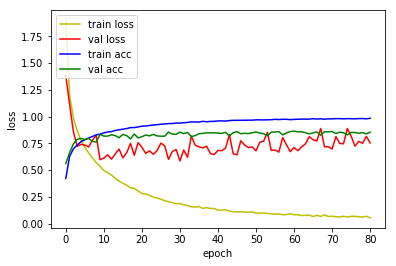

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.7079 - acc: 0.8201
Loss: 0.7078870166004138 Accuracy: 0.82014537

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9959 - acc: 0.3841
Epoch 00001: val_loss improved from inf to 1.39864, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_6_conv_checkpoint/001-1.3986.hdf5
36805/36805 [==============================] - 430s 12ms/sample - loss: 1.9961 - acc: 0.3841 - val_loss: 1.3986 - val_acc: 0.5430
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2138 - acc: 0.6169
Epoch 00002: val_loss improved from 1.39864 to 0.86774, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_6_conv_checkpoint/002-0.8677.hdf5
36805/36805 [==============================] - 423s 11ms/sample - loss: 1.2137 - acc: 0.6170 - val_loss: 0.8677 - val_acc: 0.7466
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2111 - acc: 0.9327
Epoch 00026: val_loss did not improve from 0.36210
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.2111 - acc: 0.9327 - val_loss: 0.3653 - val_acc: 0.9050
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2059 - acc: 0.9364
Epoch 00027: val_loss did not improve from 0.36210
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.2061 - acc: 0.9363 - val_loss: 0.3900 - val_acc: 0.8968
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1963 - acc: 0.9389
Epoch 00028: val_loss did not improve from 0.36210
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.1963 - acc: 0.9389 - val_loss: 0.3984 - val_acc: 0.9017
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9402
Epoch 00029: val_loss did not improve from 0.36210
36805/36805 [=====

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9761
Epoch 00056: val_loss did not improve from 0.36210
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0763 - acc: 0.9760 - val_loss: 0.3908 - val_acc: 0.9159
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0786 - acc: 0.9749
Epoch 00057: val_loss did not improve from 0.36210
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0787 - acc: 0.9748 - val_loss: 0.4213 - val_acc: 0.9099
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9728
Epoch 00058: val_loss did not improve from 0.36210
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0841 - acc: 0.9728 - val_loss: 0.4122 - val_acc: 0.9078
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9788
Epoch 00059: val_loss did not improve from 0.36210
36805/36805 [=====

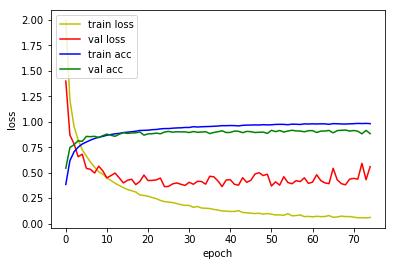

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.4514 - acc: 0.8721
Loss: 0.4514356895646821 Accuracy: 0.87206644

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3991 - acc: 0.2643
Epoch 00001: val_loss improved from inf to 1.76993, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_7_conv_checkpoint/001-1.7699.hdf5
36805/36805 [==============================] - 427s 12ms/sample - loss: 2.3991 - acc: 0.2644 - val_loss: 1.7699 - val_acc: 0.4428
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5254 - acc: 0.5048
Epoch 00002: val_loss improved from 1.76993 to 1.06657, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_7_conv_checkpoint/002-1.0666.hdf5
36805/36805 [==============================] - 419s 11ms/sample - loss: 1.5255 - acc: 0.5048 - val_loss: 1.0666 - val_acc: 0.6923
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

36800/36805 [============================>.] - ETA: 0s - loss: 0.1931 - acc: 0.9405
Epoch 00025: val_loss improved from 0.24148 to 0.21660, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_7_conv_checkpoint/025-0.2166.hdf5
36805/36805 [==============================] - 420s 11ms/sample - loss: 0.1933 - acc: 0.9404 - val_loss: 0.2166 - val_acc: 0.9408
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1965 - acc: 0.9390
Epoch 00026: val_loss did not improve from 0.21660
36805/36805 [==============================] - 420s 11ms/sample - loss: 0.1965 - acc: 0.9390 - val_loss: 0.2325 - val_acc: 0.9366
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1783 - acc: 0.9439
Epoch 00027: val_loss did not improve from 0.21660
36805/36805 [==============================] - 420s 11ms/sample - loss: 0.1784 - acc: 0.9439 - val_loss: 0.2278 - val_acc: 0.9345
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1745 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9771
Epoch 00054: val_loss did not improve from 0.21660
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0720 - acc: 0.9770 - val_loss: 0.3760 - val_acc: 0.9073
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0737 - acc: 0.9771
Epoch 00055: val_loss did not improve from 0.21660
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0738 - acc: 0.9771 - val_loss: 0.2796 - val_acc: 0.9399
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0738 - acc: 0.9768
Epoch 00056: val_loss did not improve from 0.21660
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0738 - acc: 0.9768 - val_loss: 0.2462 - val_acc: 0.9453
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0725 - acc: 0.9774
Epoch 00057: val_loss did not improve from 0.21660
36805/36805 [==================

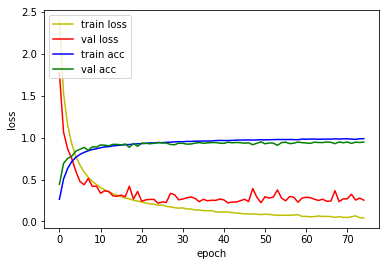

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.2694 - acc: 0.9196
Loss: 0.2693716149463832 Accuracy: 0.9196262

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4663 - acc: 0.2626
Epoch 00001: val_loss improved from inf to 1.86050, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_8_conv_checkpoint/001-1.8605.hdf5
36805/36805 [==============================] - 431s 12ms/sample - loss: 2.4662 - acc: 0.2626 - val_loss: 1.8605 - val_acc: 0.4109
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5667 - acc: 0.4987
Epoch 00002: val_loss improved from 1.86050 to 1.01159, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_8_conv_checkpoint/002-1.0116.hdf5
36805/36805 [==============================] - 418s 11ms/sample - loss: 1.5669 - acc: 0.4986 - val_loss: 1.0116 - val_acc: 0.7209
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1

36800/36805 [============================>.] - ETA: 0s - loss: 0.1606 - acc: 0.9508
Epoch 00024: val_loss did not improve from 0.16663
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.1606 - acc: 0.9508 - val_loss: 0.1682 - val_acc: 0.9534
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1386 - acc: 0.9574
Epoch 00025: val_loss did not improve from 0.16663
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.1387 - acc: 0.9574 - val_loss: 0.1741 - val_acc: 0.9509
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1413 - acc: 0.9571
Epoch 00026: val_loss did not improve from 0.16663
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.1413 - acc: 0.9571 - val_loss: 0.1692 - val_acc: 0.9541
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1262 - acc: 0.9610
Epoch 00027: val_loss improved from 0.16663 to 0.13791, saving model to model/chec

36800/36805 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9869
Epoch 00053: val_loss did not improve from 0.13791
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0442 - acc: 0.9869 - val_loss: 0.1925 - val_acc: 0.9492
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9846
Epoch 00054: val_loss did not improve from 0.13791
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0490 - acc: 0.9846 - val_loss: 0.1595 - val_acc: 0.9553
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9880
Epoch 00055: val_loss did not improve from 0.13791
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0404 - acc: 0.9880 - val_loss: 0.1692 - val_acc: 0.9574
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9868
Epoch 00056: val_loss did not improve from 0.13791
36805/36805 [==================

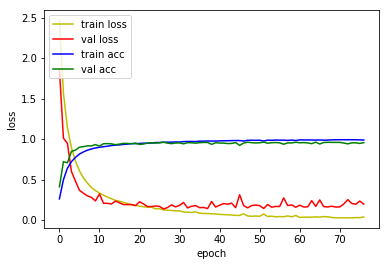

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.1775 - acc: 0.9458
Loss: 0.1774686941275468 Accuracy: 0.9457944

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3683 - acc: 0.3014
Epoch 00001: val_loss improved from inf to 1.60929, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_9_conv_checkpoint/001-1.6093.hdf5
36805/36805 [==============================] - 438s 12ms/sample - loss: 2.3683 - acc: 0.3014 - val_loss: 1.6093 - val_acc: 0.5705
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2957 - acc: 0.5954
Epoch 00002: val_loss improved from 1.60929 to 0.89735, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_9_conv_checkpoint/002-0.8974.hdf5
36805/36805 [==============================] - 419s 11ms/sample - loss: 1.2957 - acc: 0.5954 - val_loss: 0.8974 - val_acc: 0.7489
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9

36800/36805 [============================>.] - ETA: 0s - loss: 0.1292 - acc: 0.9599
Epoch 00024: val_loss did not improve from 0.12834
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.1292 - acc: 0.9599 - val_loss: 0.1519 - val_acc: 0.9567
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1144 - acc: 0.9661
Epoch 00025: val_loss improved from 0.12834 to 0.12577, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_9_conv_checkpoint/025-0.1258.hdf5
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.1144 - acc: 0.9661 - val_loss: 0.1258 - val_acc: 0.9641
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1121 - acc: 0.9669
Epoch 00026: val_loss did not improve from 0.12577
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.1121 - acc: 0.9669 - val_loss: 0.1458 - val_acc: 0.9592
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1049 - 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9890
Epoch 00053: val_loss did not improve from 0.12434
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0387 - acc: 0.9889 - val_loss: 0.1292 - val_acc: 0.9646
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9830
Epoch 00054: val_loss did not improve from 0.12434
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0544 - acc: 0.9830 - val_loss: 0.1408 - val_acc: 0.9641
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9845
Epoch 00055: val_loss did not improve from 0.12434
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0512 - acc: 0.9845 - val_loss: 0.1456 - val_acc: 0.9634
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9906
Epoch 00056: val_loss did not improve from 0.12434
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9925
Epoch 00082: val_loss did not improve from 0.12042
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0251 - acc: 0.9924 - val_loss: 0.1415 - val_acc: 0.9641
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9887
Epoch 00083: val_loss did not improve from 0.12042
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0380 - acc: 0.9887 - val_loss: 0.1450 - val_acc: 0.9627
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9959
Epoch 00084: val_loss did not improve from 0.12042
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0168 - acc: 0.9959 - val_loss: 0.1363 - val_acc: 0.9646
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0347 - acc: 0.9890
Epoch 00085: val_loss did not improve from 0.12042
36805/36805 [==================

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9966
Epoch 00112: val_loss did not improve from 0.12042
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0125 - acc: 0.9966 - val_loss: 0.1852 - val_acc: 0.9595
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9958
Epoch 00113: val_loss did not improve from 0.12042
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0155 - acc: 0.9958 - val_loss: 0.1947 - val_acc: 0.9599
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9965
Epoch 00114: val_loss did not improve from 0.12042
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0135 - acc: 0.9964 - val_loss: 0.2082 - val_acc: 0.9574
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9913
Epoch 00115: val_loss did not improve from 0.12042
36805/36805 [=

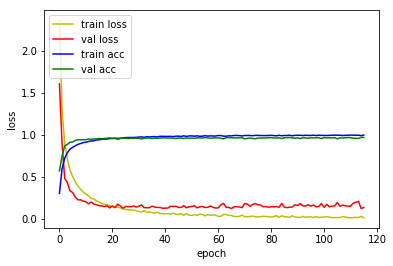

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.1566 - acc: 0.9589
Loss: 0.15657237921512626 Accuracy: 0.9588785



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_4_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_4_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.4514 - acc: 0.8721
Loss: 0.4514356895646821 Accuracy: 0.87206644

1D_CNN_custom_4_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_61 (Activation)   (None, 1

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.1775 - acc: 0.9458
Loss: 0.1774686941275468 Accuracy: 0.9457944

1D_CNN_custom_4_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_76 (Activation)   (None, 16

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333

4815/4815 [==============================] - 19s 4ms/sample - loss: 0.6862 - acc: 0.8525
Loss: 0.6862390321115591 Accuracy: 0.8525441

1D_CNN_custom_4_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_61 (Activation)   (None, 16

4815/4815 [==============================] - 19s 4ms/sample - loss: 0.2508 - acc: 0.9410
Loss: 0.2507669526128135 Accuracy: 0.9410176

1D_CNN_custom_4_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_76 (Activation)   (None, 16